In [28]:
import pickle
from MP.MP import MP
import os
import pandas as pd
import numpy as np
import sys


input_path = './data/MoniteringResults/'
out_path = "./data/MR_CSV/"
file_list = os.listdir(input_path)
# Load function
def load(path):
    with open(path,"rb") as f:
        return pickle.load(f)
# Converting 'apply_to_all' results to csv files and calculate period
def cal_period(intersection):
    out = out_path + "/" + intersection
    if not os.path.exists(out):
        dic = load(input_path+intersection)
        if dic is None:
            return
        trends, direction = dic['trends'], dic['dirs']
        seq = pan_duan_fang_xiang(direction)
        records = pd.DataFrame(trends)
        records = records.iloc[seq,:]
        records.index = range(4)
        records.transpose().to_csv(out)
    os.system('Rscript Period.r '+out)

def pan_duan_fang_xiang(directions):
    directions = np.array(directions)
    similarity = np.dot(directions, directions.T)
    pairs = similarity.argmin(axis=1)
    result = range(4)
    temp = result[1]
    result[1] = result[pairs[0]]
    result[pairs[0]] = temp
    return result

mp=MP(cal_period,24)
mp.set_jobs(file_list)
mp.execute(verbose=1)
print "Done!"

Executed by 0, elasped time: 0.0
Executed by 1, elasped time: 0.0
Executed by 2, elasped time: 0.0
Executed by 7, elasped time: 0.0
Executed by 7, elasped time: 0.0
Executed by 8, elasped time: 0.0
Executed by 20, elasped time: 0.0
Executed by 14, elasped time: 9.0
Executed by 4, elasped time: 9.5
Executed by 3, elasped time: 9.5
Executed by 18, elasped time: 9.6
Executed by 8, elasped time: 9.7
Executed by 23, elasped time: 9.7
Executed by 0, elasped time: 10.0
Executed by 2, elasped time: 10.3
Executed by 17, elasped time: 10.3
Executed by 12, elasped time: 10.5
Executed by 20, elasped time: 10.4
Executed by 20, elasped time: 0.0
Executed by 9, elasped time: 10.6
Executed by 22, elasped time: 10.6
Executed by 13, elasped time: 10.9
Executed by 19, elasped time: 11.7
Executed by 6, elasped time: 12.2
Executed by 16, elasped time: 12.4
Executed by 10, elasped time: 12.5
Executed by 15, elasped time: 12.6
Executed by 5, elasped time: 12.7
Executed by 21, elasped time: 13.1
Executed by 7

In [79]:
with open('./data/periods.csv', 'w') as r:
    for whatever in [i for i in os.listdir('./periods/') if not i.startswith('.')]:
        with open('./periods/'+whatever,'r') as f:
            next(f)
            dirs = []
            for line in f:
                dirs.append(line.strip().split(',')[1:])
            dirs = np.array(dirs, int).T
            dirs = dirs[(dirs>30).prod(axis=1)==1,:]
            if len(dirs)==0:
                continue
            idx = np.apply_along_axis(np.var, axis=1, arr=dirs).argmin()
            period = dirs[idx].mean()
            r.write(whatever.split('_')[1].split('.')[0]+','+str(period)+'\n')
print 'Done.'


Done.


In [108]:
%matplotlib inline
from matplotlib import pyplot as plt
from pandas import DataFrame
import pandas as pd
import numpy as np
import os

TRAJ_DIR = "./data/Trajectories/"
tids = os.listdir(TRAJ_DIR)

def plotTraj(df,alp=1):
    plt.plot(np.array(df[2]),np.array(df[3]),color='b',alpha=alp)

def spliTraj(df,threshold,isplot):
    curr, last = None, None
    split=[0]
    for i in xrange(df.shape[0]):
        if type(curr)!=type(None):
            last=curr
        curr = df.iloc[i,2:4]
        if type(last)!=type(None):
            if ((last-curr)**2).sum()>threshold:
                split.append(i)
    split.append(i+1)
    #return split
    ret = []
    for i in xrange(1,len(split)):
        splited=df.iloc[split[i-1]:split[i],:]
        if splited.shape[0]>5:
            if isplot: plotTraj(splited,isplot)
            ret.append(splited)
    return ret
                   
def readTraj(tid,isSplit=False,threshold=.0003,isplot=False):
    path=TRAJ_DIR+tid
    dfs=[]
    with open(path,"rb") as f:
        data = []
        for i in f:
            tmp = i.strip().split(",")
            range_conditions=(float(tmp[3])>23.1 or float(tmp[3])<22.4)and(float(tmp[2])>113.6 or float(tmp[2])<114.6)
            if range_conditions:
                return []
            data.append([int(tmp[0]),tmp[1],float(tmp[2]),float(tmp[3])])
    df=DataFrame(data).sort(1)
    if not isSplit: 
        if isplot:plotTraj(df,isplot)
        return df
    dfs+=spliTraj(df,threshold,isplot)
    return dfs

In [109]:
with open("./data/periods.csv") as f:
    res= []
    for i in f:
        res.append(i.split(","))

df2 = np.array(res,float)

with open("./data/intersections","rb") as f:
    res=[]
    for i in f:
        res.append(i.strip().split(","))
        
df = pd.DataFrame(res)


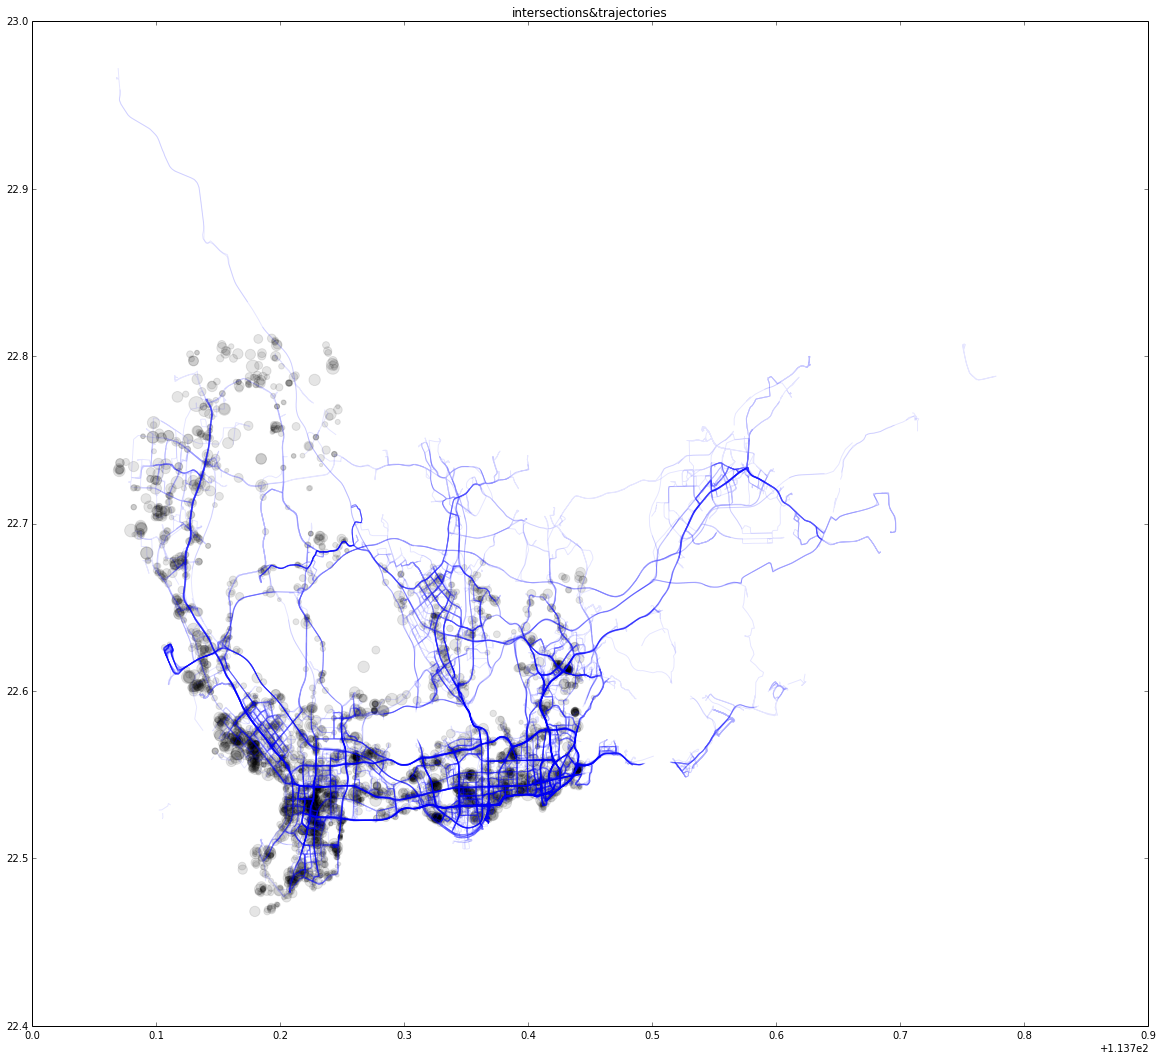

In [117]:
plt.figure(figsize=(20,18))
dfs = []
N=100
for i in xrange(N):
    readTraj(tids[i],True,0.0001,isplot=.1)


df[0],df[1],df[2] = df[0].astype(int),df[1].astype(float),df[2].astype(float)

for i in df2:
    idx = int(i[0])
    plt.scatter(df.ix[idx,1],df.ix[idx,2],s=i[1]/5,alpha=0.1,color="k")

plt.title("intersections&trajectories")
plt.show()

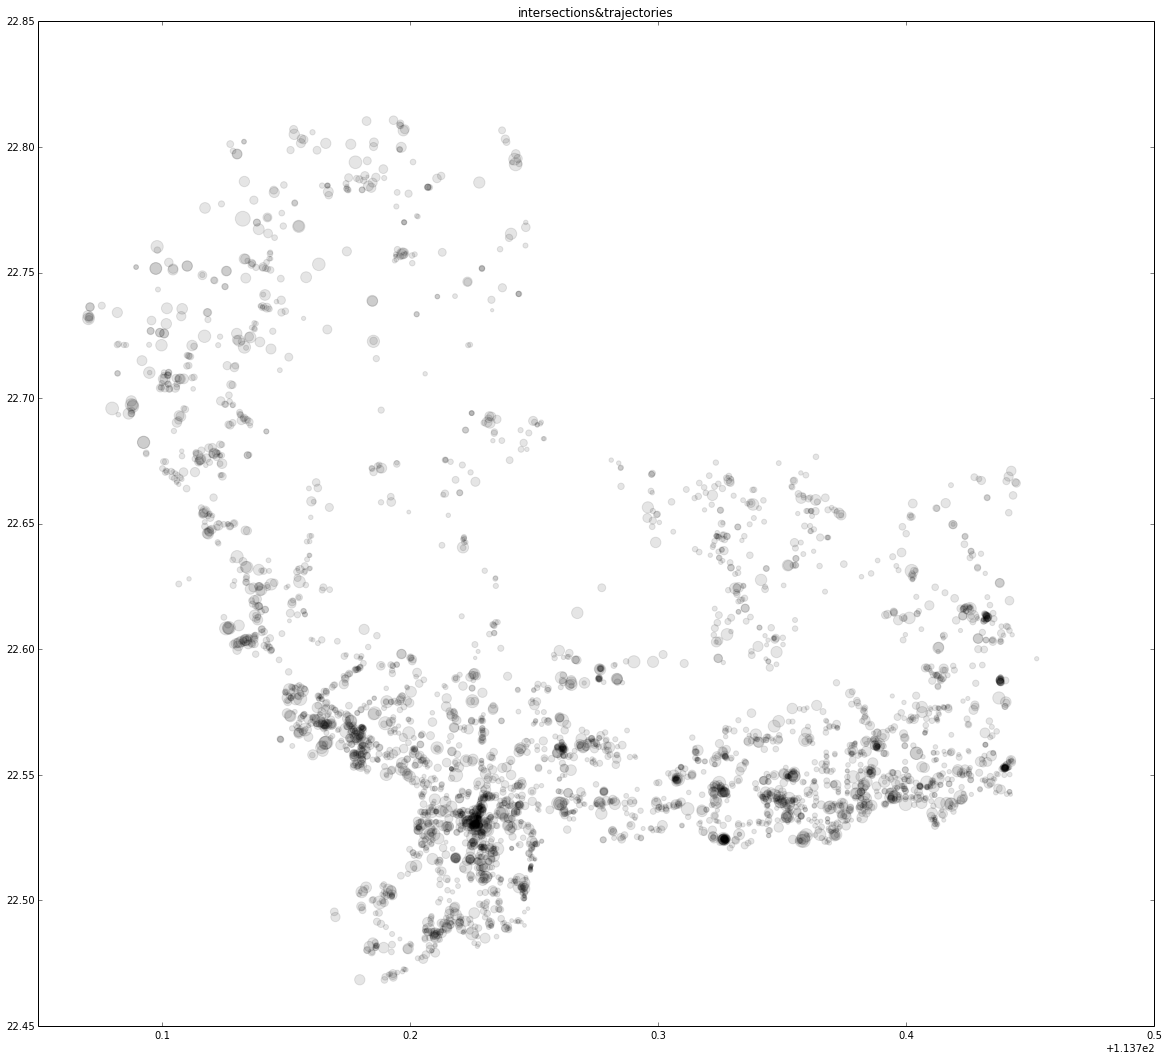

In [116]:
plt.figure(figsize=(20,18))
for i in df2:
    idx = int(i[0])
    plt.scatter(df.ix[idx,1],df.ix[idx,2],s=i[1]/5,alpha=0.1,color="k")

plt.title("intersections&trajectories")
plt.show()

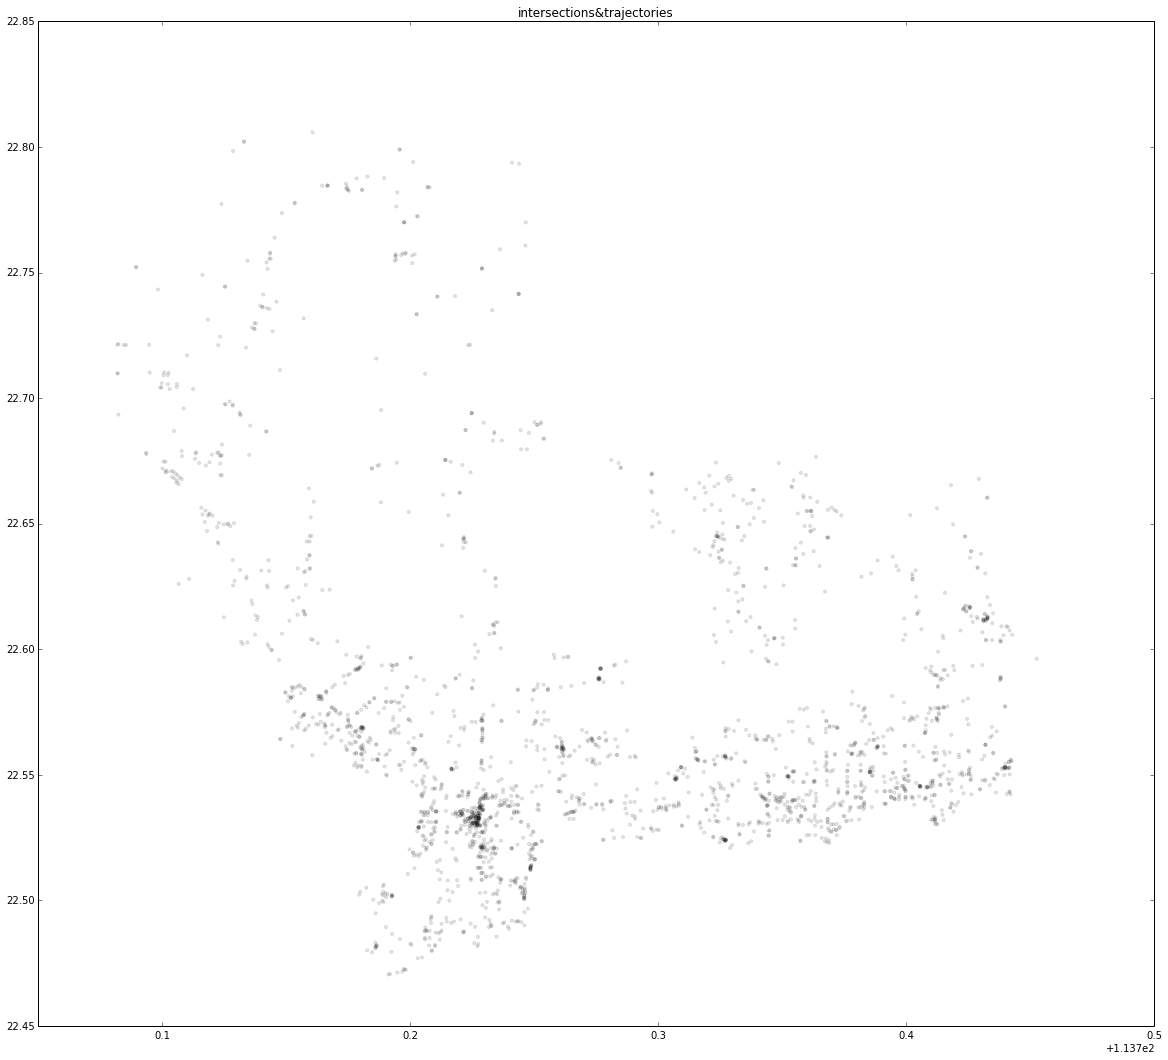

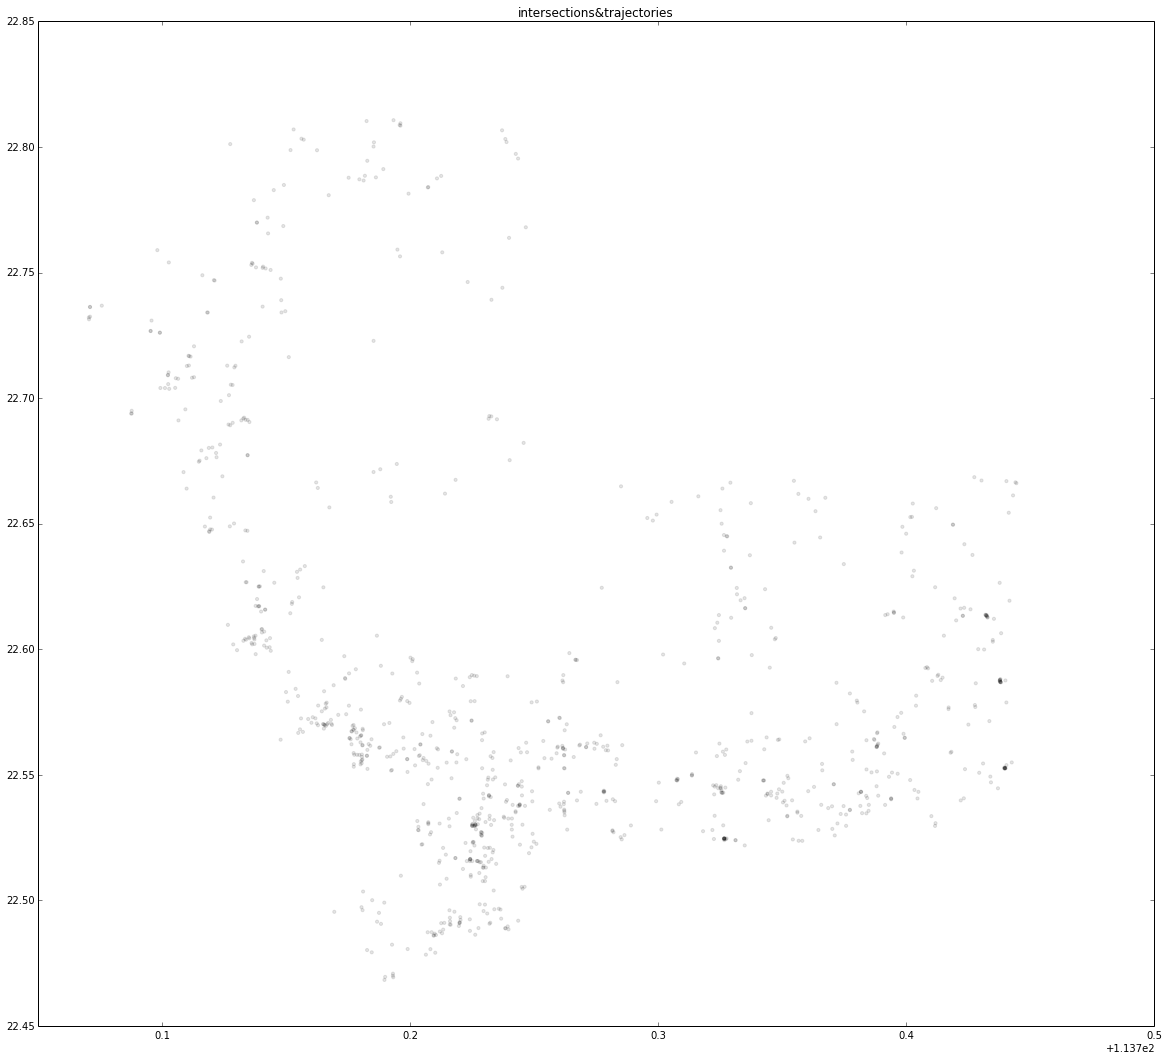

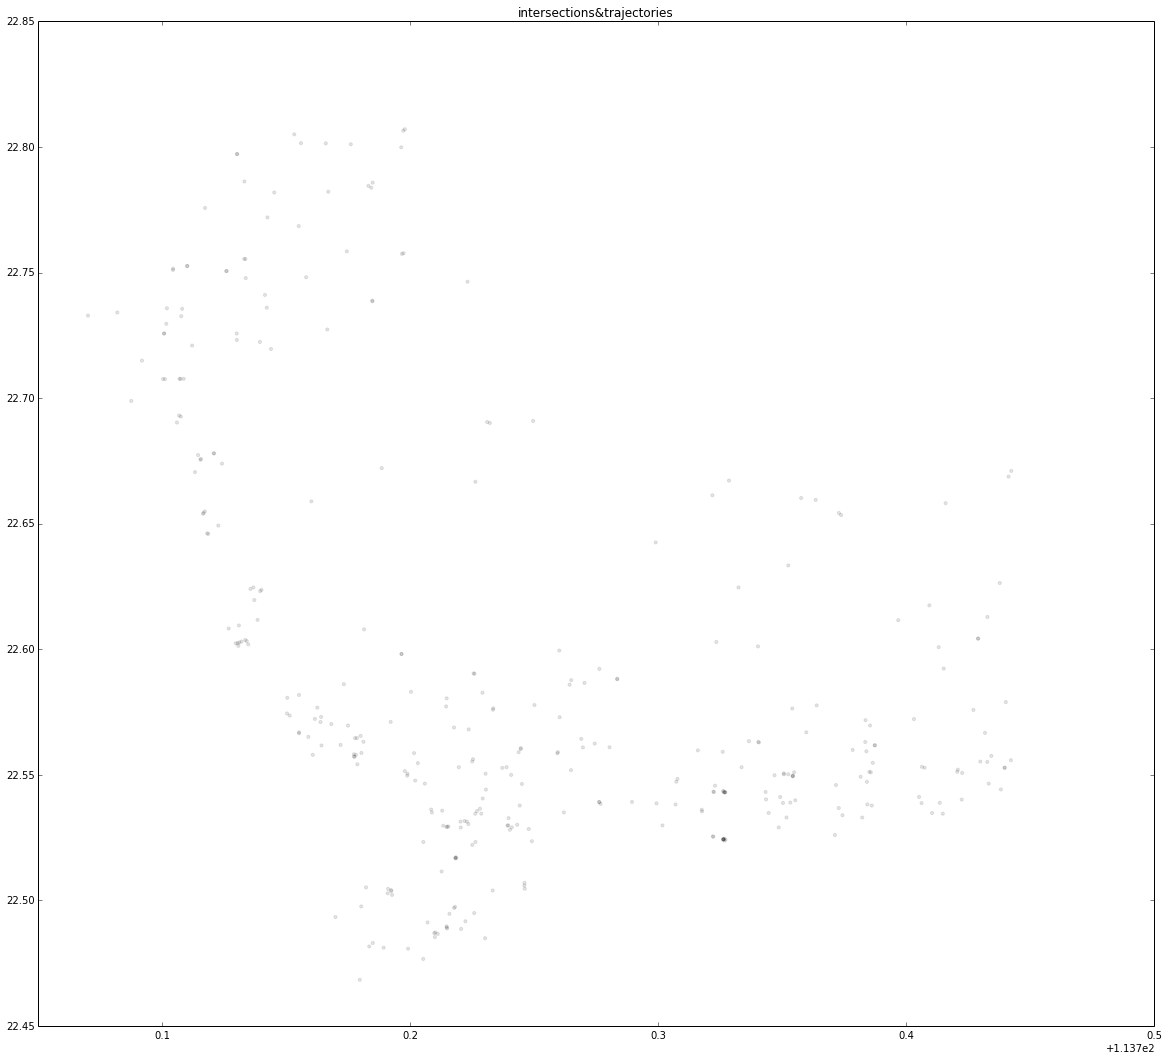

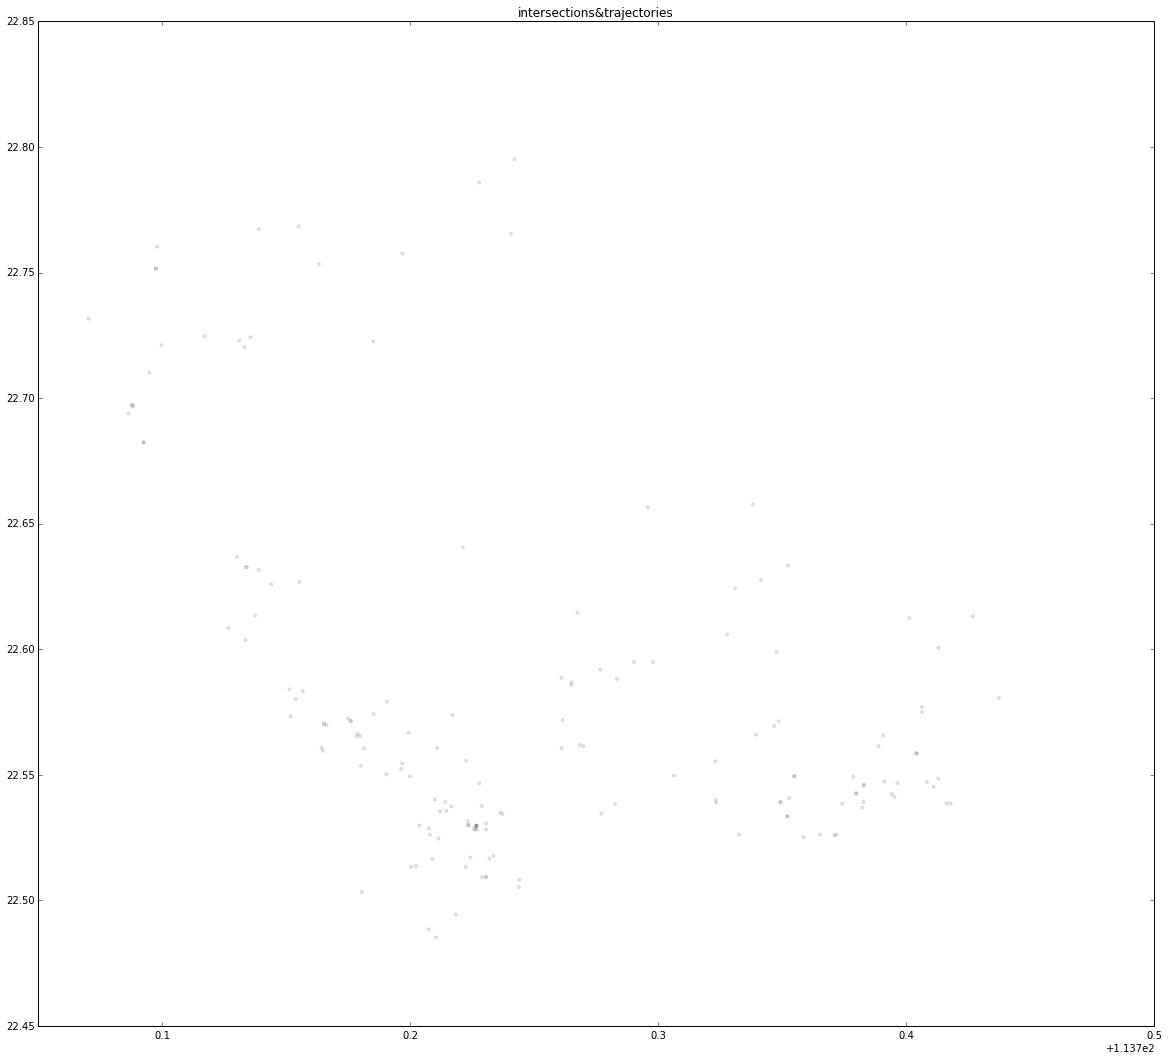

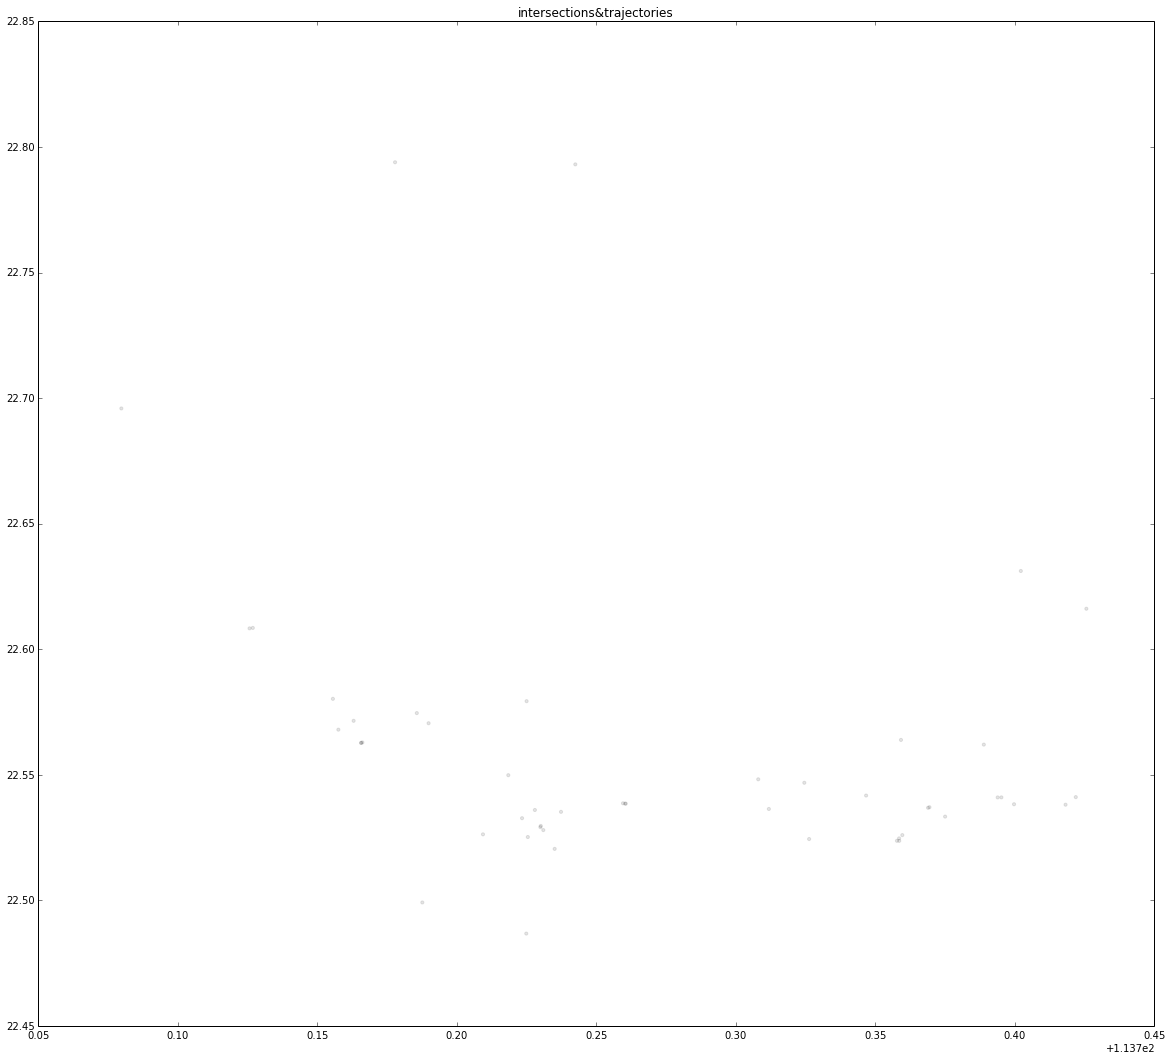

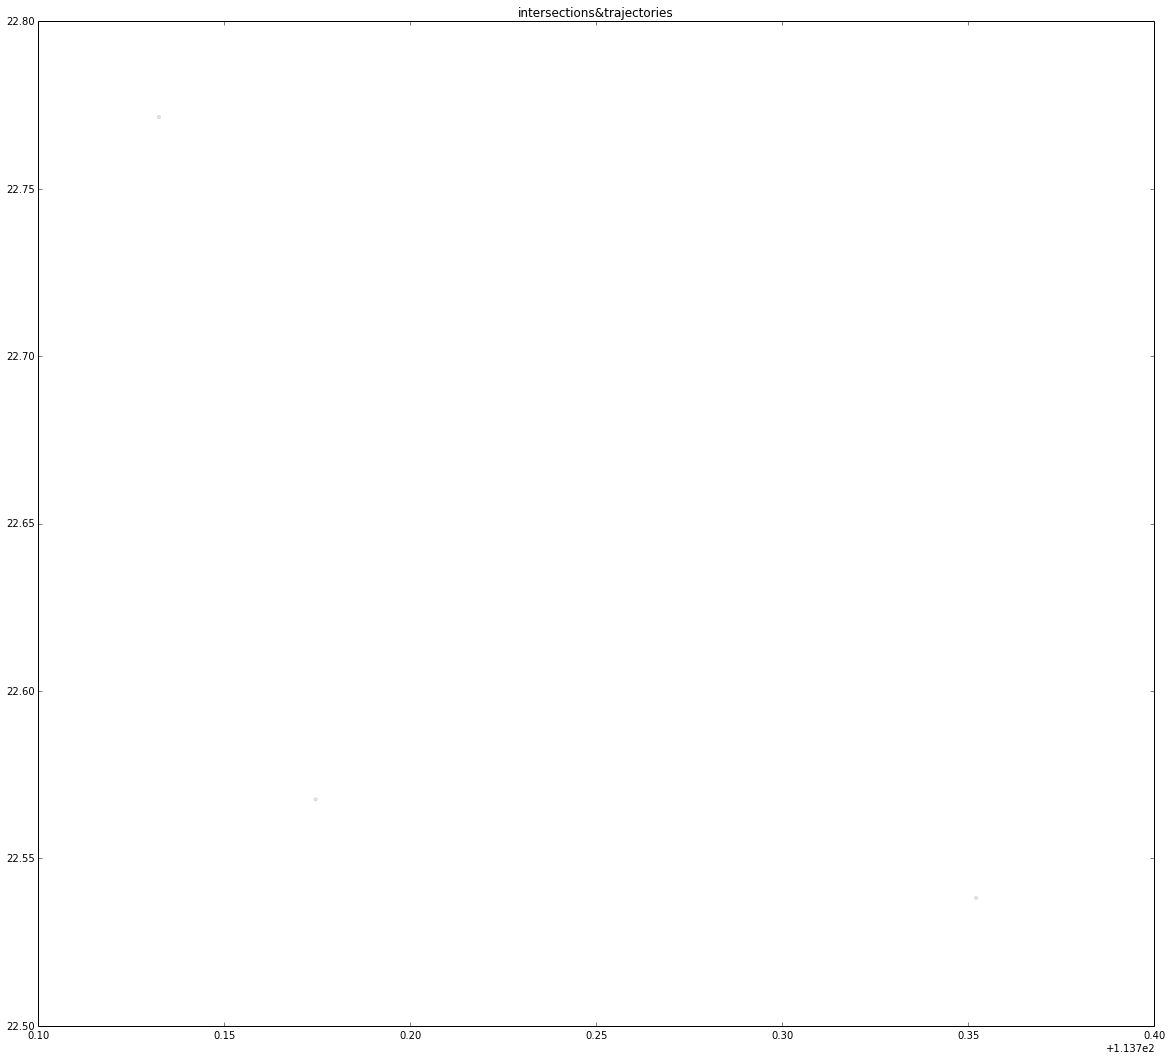

In [120]:
rng = [0,200,400,600,800,1000,2000]
for j in xrange(len(rng)-1):
    plt.figure(figsize=(20,18))
    for i in df2:
        idx = int(i[0])
        if i[1]>rng[j] and i[1]<=rng[j+1]:
            plt.scatter(df.ix[idx,1],df.ix[idx,2],s=10,alpha=0.1,color="k")
    plt.title("intersections&trajectories")
    plt.show()